In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import numpy as np
from numpy import array
from IPython.display import display
import pandas as pd
import seaborn as sns
import urllib.request
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


# Part A: Data Setup

In [ ]:
# data preprocessing

urllib.request.urlretrieve("https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/set4/data/COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv", "COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")
df = pd.read_csv("COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")

# TODO: preprocess df

# convert all death_yn with missing/unknown to NaN

df['death_yn'] = df['death_yn'].replace(['Missing'], np.NAN)
df['death_yn'] = df['death_yn'].replace(['Unknown'], np.NAN)

# convert date strings to date time using to_datetime

df['cdc_case_earliest_dt '] = pd.to_datetime(df['cdc_case_earliest_dt '])
df['cdc_report_dt'] = pd.to_datetime(df['cdc_report_dt'])
df['pos_spec_dt'] = pd.to_datetime(df['pos_spec_dt'])
df['onset_dt'] = pd.to_datetime(df['onset_dt'])

# add column of start date in front of df

df = df.assign(start_date = ['2020/01/20'] * len(df))
first = df.pop('start_date')
df.insert(1, 'start_date', first)

# convert and subtract from all dates

df['start_date'] = pd.to_datetime(df['start_date'])

df['cdc_case_earliest_dt '] = (df['cdc_case_earliest_dt '] - df['start_date']) / np.timedelta64(1,'D')
df['cdc_report_dt'] = (df['cdc_report_dt'] - df['start_date']) / np.timedelta64(1,'D')
df['pos_spec_dt'] = (df['pos_spec_dt'] - df['start_date']) / np.timedelta64(1,'D')
df['onset_dt'] = (df['onset_dt'] - df['start_date']) / np.timedelta64(1,'D')

# drop rows with NaN values in death_yn pos_spec_dt onset_d

df = df.dropna(subset = ['death_yn'])
df = df.dropna(subset = ['pos_spec_dt'])
df = df.dropna(subset = ['onset_dt'])

# factorize columns

df[['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']] = df[['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']].apply(lambda x: pd.factorize(x)[0])

display(df)


,Unnamed: 0,start_date,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,0,2020-01-20,203.0,769.0,207.0,203.0,0,0,0,0,0,0,0,0
39,39,2020-01-20,648.0,653.0,651.0,648.0,0,1,1,1,0,1,0,1
49,49,2020-01-20,315.0,470.0,317.0,315.0,0,1,1,2,1,1,0,2
60,60,2020-01-20,754.0,771.0,755.0,754.0,0,0,2,1,1,1,0,2
65,65,2020-01-20,257.0,273.0,266.0,257.0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799878,799878,2020-01-20,728.0,728.0,728.0,728.0,0,1,3,1,2,2,0,3
799882,799882,2020-01-20,677.0,688.0,679.0,677.0,0,1,2,1,0,1,0,2
799894,799894,2020-01-20,352.0,352.0,353.0,352.0,0,0,4,1,0,0,0,0
799938,799938,2020-01-20,627.0,627.0,639.0,627.0,0,1,4,3,0,0,0,1


In [ ]:
# TODO: make sure your data can be converted to torch tensors

train_X, test_X, train_y, test_y = train_test_split(df.iloc[:,[4,5,6,7,8,9,10,11,13]], df['death_yn'], test_size = 0.2)

# normalize training and data

scaler = StandardScaler()

scaler.fit(train_X.iloc[:,[4,5]])

train_X.iloc[:,[4,5]] = scaler.transform(train_X.iloc[:,[4,5]])
test_X.iloc[:,[4,5]] = scaler.transform(test_X.iloc[:,[4,5]])

# make datasets and dataloaders

tensor_train_X = torch.Tensor(train_X.to_numpy())
tensor_train_y = torch.Tensor(train_y.to_numpy()).type(torch.LongTensor)
tensor_test_X = torch.Tensor(test_X.to_numpy())
tensor_test_y = torch.Tensor(test_y.to_numpy()).type(torch.LongTensor)

train_dataset = TensorDataset(tensor_train_X, tensor_train_y)
test_dataset = TensorDataset(tensor_test_X, tensor_test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


# Part B: Linear Neural Network

## Model Setup

In [ ]:
# TODO: Make your model, optmizer, and loss function here.

model = nn.Sequential(
    nn.Linear(9, 5),
    nn.Softmax()
)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

Sequential(
  (0): Linear(in_features=9, out_features=5, bias=True)
  (1): Softmax(dim=None)
)


## Training Loop

In [ ]:
# Some layers, such as Dropout, behave differently during training

model.train()

# TODO: Write your training loop here.

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1  Loss: 0.9048
Train Epoch: 2  Loss: 0.9048
Train Epoch: 3  Loss: 0.9048
Train Epoch: 4  Loss: 0.9048
Train Epoch: 5  Loss: 0.9048
Train Epoch: 6  Loss: 0.9048
Train Epoch: 7  Loss: 0.9048
Train Epoch: 8  Loss: 0.9048
Train Epoch: 9  Loss: 1.0298
Train Epoch: 10  Loss: 0.9048


## Testing Loop

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    # TODO: Write test loop here.
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

# TODO: Show results.
print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' % (test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))



Test set: Average loss: 0.0291, Accuracy: 11581/11875 (97.5242)


## Weight Matrix Visualization

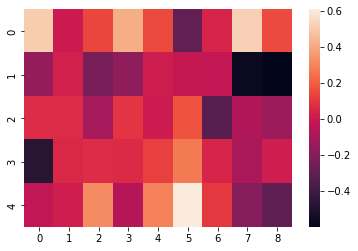

In [ ]:
weights = model.state_dict()['0.weight']
sns.heatmap(weights)

# Part C: 2-Layer Linear Model

In [ ]:
# TODO: Repeat for 2-layer model

model_2 = nn.Sequential(
    nn.Linear(9, 7),
    nn.Linear(7, 5),
    nn.Softmax()
)
print(model_2)

optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

Sequential(
  (0): Linear(in_features=9, out_features=7, bias=True)
  (1): Linear(in_features=7, out_features=5, bias=True)
  (2): Softmax(dim=None)
)


In [ ]:
# Some layers, such as Dropout, behave differently during training

model_2.train()

# TODO: Write your training loop here.

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model_2(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.9048
Train Epoch: 2  Loss: 0.9048
Train Epoch: 3  Loss: 0.9048
Train Epoch: 4  Loss: 0.9048
Train Epoch: 5  Loss: 0.9048
Train Epoch: 6  Loss: 0.9048
Train Epoch: 7  Loss: 0.9048
Train Epoch: 8  Loss: 0.9048
Train Epoch: 9  Loss: 1.0298
Train Epoch: 10  Loss: 0.9048


In [ ]:
# Putting layers like Dropout into evaluation mode
model_2.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    # TODO: Write test loop here.
    for data, target in test_loader:
        output = model_2(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

# TODO: Show results.
print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' % (test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0291, Accuracy: 11581/11875 (97.5242)
